# Spotify Song Prediction

### Handling Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV


### Loading the dataset

In [2]:
df = pd.read_csv('spotify_songs.csv')
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


## Data Preprocessing

In [3]:
# Defining the columns that are irrelevant for our case
columns_to_drop = ['track_id', 'track_artist', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id']
df.drop(columns=columns_to_drop, inplace=True)
df.dropna(axis=0, inplace=True)

# Dropping the samples that are too short
rows_to_drop = df.loc[df['duration_ms'] < 20000].index
df.drop(rows_to_drop, inplace=True)

new_df = df.copy()

##### Dealing with the date feature

In [ ]:
# Splitting the date to subsections
new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# Convert the columns to numeric (to handle missing values during median calculation)
new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')

# Calculate median values for year, month, and day
median_year = int(new_df['year'].median())

# Fill missing values with median values
new_df['year'] = new_df['year'].fillna(median_year).astype(int)

X = new_df.drop(['track_popularity', 'track_album_release_date', 'month', 'day'], axis=1)

X = pd.get_dummies(X, dtype=int)
X['year'] = new_df['year']
y = new_df['track_popularity']

In [4]:
# X.tail()
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'year', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subge

In [5]:
df.iloc[3446]
X.iloc[3446]

danceability                                        0.63000
energy                                              0.52600
key                                                 7.00000
loudness                                           -9.12100
mode                                                1.00000
speechiness                                         0.03890
acousticness                                        0.31600
instrumentalness                                    0.00538
liveness                                            0.07470
valence                                             0.61000
tempo                                             145.27100
duration_ms                                    215333.00000
year                                             1981.00000
playlist_genre_edm                                  0.00000
playlist_genre_latin                                0.00000
playlist_genre_pop                                  1.00000
playlist_genre_r&b                      

##### Splitting the dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

(array([3985.,  861.,  742.,  759.,  872.,  872., 1028., 1211., 1549.,
        1808., 1820., 1903., 1974., 1984., 2008., 1959., 1795., 1686.,
        1355., 1149.,  648.,  422.,  248.,  123.,   71.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100.]),
 <BarContainer object of 25 artists>)

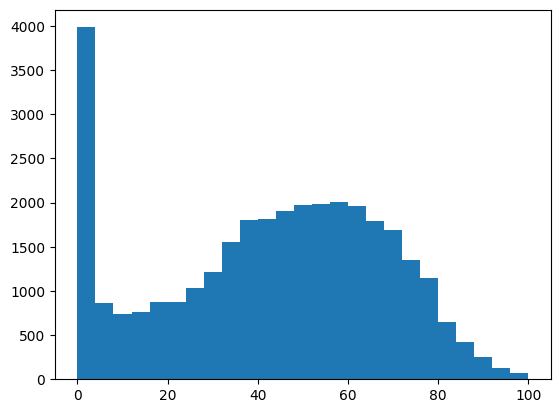

In [7]:
plt.hist(y, bins=25)

In [8]:
X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,playlist_subgenre_new jack swing,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary
count,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,...,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000
mean,0.654869,0.698631,5.374604,-6.718909,0.565698,0.107071,0.175339,0.084750,0.190182,0.510577,...,0.034509,0.033656,0.046205,0.034387,0.055099,0.028905,0.051017,0.039321,0.039230,0.042794
std,0.145043,0.180900,3.611632,2.986570,0.495673,0.101314,0.219634,0.224233,0.154316,0.233132,...,0.182535,0.180345,0.209932,0.182224,0.228176,0.167541,0.220036,0.194361,0.194145,0.202395
min,0.077100,0.000175,0.000000,-46.448000,0.000000,0.022400,0.000001,0.000000,0.009360,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Defining the numeric and dummy feats

In [9]:
print(X.columns)

numeric_feats = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
dummy_feats = [feat for feat in X.columns if feat not in numeric_feats]

print(X[numeric_feats])

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'year', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subge

##### Correlation matrix

<Axes: >

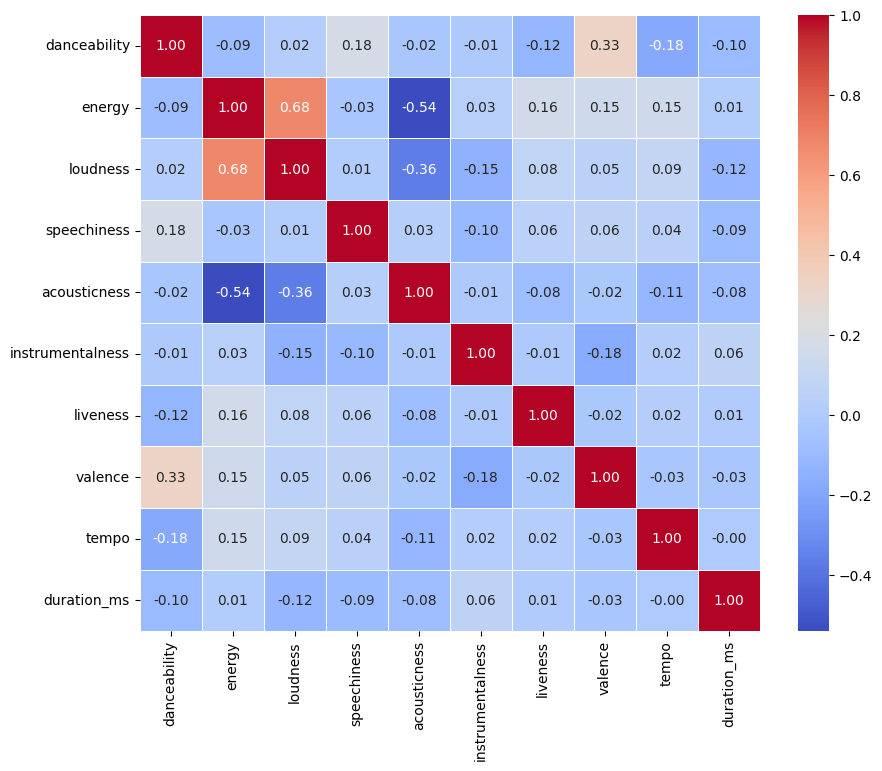

In [10]:
# Extracting the numeric values
numeric_values = df[numeric_feats]

# Plotting the matrix
correlation_matrix = numeric_values.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

##### Model evaluation

In [11]:
def model_evaluation(y_test, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1 - ((1 - r2) * (N - 1)) / (N - d - 1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    res = pd.concat([pd.DataFrame(y_test.values),
                    pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return mse, mae, rmse, r2, r2_adj

##### Scaling the data

In [12]:
s = StandardScaler()
s.fit(X_train[numeric_feats])
X_train_std = s.transform(X_train[numeric_feats])
X_test_std = s.transform(X_test[numeric_feats])
X_train_std = pd.DataFrame(X_train_std)
X_test_std = pd.DataFrame(X_test_std)

X_train_std = pd.concat([X_train_std, X_train[dummy_feats].reset_index(drop=True)], axis=1)
X_test_std = pd.concat([X_test_std, X_test[dummy_feats].reset_index(drop=True)], axis=1)

X_train_std.columns = list(X.columns)
X_test_std.columns = list(X.columns)
X_train_std.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,playlist_subgenre_new jack swing,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary
0,0.622867,-2.212089,-0.307576,-0.709015,2.267368,-0.377976,0.650536,-0.878447,-0.964504,-0.112134,...,0,0,0,0,0,0,0,0,0,0
1,-2.670088,1.406350,0.609448,-0.110755,-0.786554,-0.377986,0.598812,0.245905,-1.334977,0.696852,...,0,0,0,0,0,0,0,0,0,0
2,-1.168280,-1.033607,-0.116544,-0.722836,-0.758601,-0.377986,-0.564964,-0.775453,0.931639,-0.146528,...,0,1,0,0,0,0,0,0,0,0
3,-1.154502,-1.481762,-1.237313,-0.816622,-0.432978,-0.350407,0.049251,-1.238926,-1.190485,-0.252741,...,0,0,0,0,0,0,0,0,0,0
4,-1.120057,0.875203,1.367222,-0.411859,-0.413888,-0.377952,0.993203,-0.505093,0.338086,-0.053085,...,0,0,1,0,0,0,0,0,0,0


## Pre-PCA

### Linear Regression

##### Base LR

In [71]:
# Define the hyperparameters grid
param_grid = {
    'fit_intercept': [True, False],
}

# Instantiate the linear regression model
lr = LinearRegression()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train_std, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

best_lr_b = grid_search.best_estimator_

Best Parameters: {'fit_intercept': False}
Best Score (MSE): 528.8904495687236


#### Base Lasso

In [72]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],  # regularization strength
    'fit_intercept': [True, False]
}

# Instantiate the Lasso regression model
lasso = Lasso()

# Instantiate GridSearchCV
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_lasso.fit(X_train_std, y_train)

# Get the best parameters and best score
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = grid_search_lasso.best_score_

print("Best Parameters for Lasso:", best_params_lasso)
print("Best Score (MSE) for Lasso:", -best_score_lasso)

best_lasso_b = grid_search_lasso.best_estimator_

Best Parameters for Lasso: {'alpha': 0.1, 'fit_intercept': True}
Best Score (MSE) for Lasso: 533.9165342446629


#### Base Ridge

In [75]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],  # regularization strength
    'fit_intercept': [True, False]
}

# Instantiate the Ridge regression model
ridge = Ridge()

# Instantiate GridSearchCV
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_ridge.fit(X_train_std, y_train)

# Get the best parameters and best score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

print("Best Parameters for Ridge:", best_params_ridge)
print("Best Score (MSE) for Ridge:", -best_score_ridge)

best_ridge_b = grid_search_ridge.best_estimator_

Best Parameters for Ridge: {'alpha': 10.0, 'fit_intercept': True}
Best Score (MSE) for Ridge: 528.8860811497022


### Poly hypothesis

In [53]:
poly = PolynomialFeatures(interaction_only=False, degree=2, include_bias=True)
X_inter_train = poly.fit_transform(X_train_std)
X_inter_test = poly.transform(X_test_std)
out_feat_names = PolynomialFeatures.get_feature_names_out(
    poly, input_features=None)

#### LR Poly

In [74]:
# Define the hyperparameters grid
param_grid = {
    'fit_intercept': [True, False],
}

# Instantiate the linear regression model
lr = LinearRegression()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_inter_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

best_lr_p = grid_search.best_estimator_

Best Parameters: {'fit_intercept': False}
Best Score (MSE): 496.5013231365162


##### Lasso Poly

In [76]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],  # regularization strength
    'fit_intercept': [True, False]
}

# Instantiate the Lasso regression model
lasso = Lasso()

# Instantiate GridSearchCV
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_lasso.fit(X_inter_train, y_train)

# Get the best parameters and best score
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = grid_search_lasso.best_score_

print("Best Parameters for Lasso:", best_params_lasso)
print("Best Score (MSE) for Lasso:", -best_score_lasso)

best_lasso_p = grid_search_lasso.best_estimator_

/home/srdjan/dev/python/spotify-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+06, tolerance: 1.476e+03
  model = cd_fast.enet_coordinate_descent(
/home/srdjan/dev/python/spotify-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.275e+06, tolerance: 1.476e+03
  model = cd_fast.enet_coordinate_descent(
/home/srdjan/dev/python/spotify-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, c

Best Parameters for Lasso: {'alpha': 0.1, 'fit_intercept': True}
Best Score (MSE) for Lasso: 518.2419710099323


/home/srdjan/dev/python/spotify-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.382e+06, tolerance: 1.850e+03
  model = cd_fast.enet_coordinate_descent(


#### Ridge Poly

In [81]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],  # regularization strength
    'fit_intercept': [True, False]
}

# Instantiate the Ridge regression model
ridge = Ridge()

# Instantiate GridSearchCV
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_ridge.fit(X_train_std, y_train)

# Get the best parameters and best score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

print("Best Parameters for Ridge:", best_params_ridge)
print("Best Score (MSE) for Ridge:", -best_score_ridge)

best_ridge_p = grid_search_ridge.best_estimator_

Best Parameters for Ridge: {'alpha': 10.0, 'fit_intercept': True}
Best Score (MSE) for Ridge: 528.8860811497022


### SVR

In [69]:
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]
}

# Instantiate SVR
svr = SVR()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# Fit grid search to training data
random_search.fit(X_train_std, y_train)

# Get the best parameters and best score
best_params_svr = random_search.best_params_
best_score_svr = random_search.best_score_

print("Best Parameters for SVR:", best_params_svr)
print("Best Score (MSE) for SVR:", -best_score_svr)

# Access best model
best_svr = random_search.best_estimator_

Best Parameters for SVR: {'kernel': 'linear', 'epsilon': 0.1, 'degree': 3, 'C': 1}
Best Score (MSE) for SVR: 536.9701303634046


In [24]:
# # Define hyperparameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.01, 0.1, 1],
#     'kernel': ['linear', 'rbf', 'sigmoid'],
#     'degree': [2, 3, 4]
# }

# # Instantiate SVR
# svr = SVR()

# # Instantiate RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# # Fit random search to training data
# random_search.fit(X_train_std, y_train)

# # Access best model and parameters
# best_model = random_search.best_estimator_
# best_params = random_search.get_params

# # Evaluate best model on testing data
# y_pred = best_model.predict(X_test_std)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

Best Model Parameters: <bound method BaseEstimator.get_params of RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'degree': [2, 3, 4],
                                        'epsilon': [0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf', 'sigmoid']},
                   scoring='neg_mean_squared_error')>
MSE: 517.6773419846639
R-squared: 0.14804400310584365


### DTR

In [86]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=27)

# Instantiate GridSearchCV
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# Fit grid search to training data
random_search.fit(X_train_std, y_train)

# Get the best parameters and best score
best_params_dt = random_search.best_params_
best_score_dt = random_search.best_score_

print("Best Parameters for Decision Tree:", best_params_dt)
print("Best Score (MSE) for Decision Tree:", -best_score_dt)

# Access best model
best_dtr = random_search.best_estimator_

Best Parameters for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Best Score (MSE) for Decision Tree: 533.6375865307957


In [27]:
# # Define hyperparameter grid
# param_grid = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Instantiate decision tree regressor
# dt = DecisionTreeRegressor(random_state=27)

# # Instantiate RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# # Fit random search to training data
# random_search.fit(X_train_std, y_train)

# # Access best model and parameters
# best_model = random_search.best_estimator_
# best_params = random_search.best_params_

# # Evaluate best model on testing data
# y_pred = best_model.predict(X_test_std)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

Best Model Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
MSE: 508.34183227728727
R-squared: 0.16340771102624707


## PCA
The models are being re-trained the same way but with PCA train data

In [87]:
# Applying the PCA
pca = PCA(n_components=0.99)  # Specify the variance to be preserved
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Inspecting the explained variance ratio to decide the number of components
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

Explained variance ratio: [0.84076063 0.08409327 0.01391304 0.01019054 0.00726657 0.00653442
 0.00628904 0.00564641 0.00510138 0.00399229 0.00319016 0.00154143
 0.00149161]
Cumulative explained variance ratio: [0.84076063 0.9248539  0.93876694 0.94895749 0.95622406 0.96275848
 0.96904752 0.97469393 0.97979531 0.9837876  0.98697776 0.98851919
 0.9900108 ]


#### Linear Regression PCA

In [88]:
# Define the hyperparameters grid
param_grid = {
    'fit_intercept': [True, False],
}

# Instantiate the linear regression model
lr = LinearRegression()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", -best_score)

best_lr_pca = grid_search.best_estimator_

Best Parameters: {'fit_intercept': True}
Best Score (MSE): 579.4818704323152


#### Lasso PCA

In [89]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],  # regularization strength
    'fit_intercept': [True, False]
}

# Instantiate the Lasso regression model
lasso = Lasso()

# Instantiate GridSearchCV
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_lasso.fit(X_train_pca, y_train)

# Get the best parameters and best score
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = grid_search_lasso.best_score_

print("Best Parameters for Lasso:", best_params_lasso)
print("Best Score (MSE) for Lasso:", -best_score_lasso)

best_lasso_pca = grid_search_lasso.best_estimator_

Best Parameters for Lasso: {'alpha': 0.1, 'fit_intercept': True}
Best Score (MSE) for Lasso: 579.6668131570975


#### Ridge PCA

In [90]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],  # regularization strength
    'fit_intercept': [True, False]
}

# Instantiate the Ridge regression model
ridge = Ridge()

# Instantiate GridSearchCV
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_ridge.fit(X_train_pca, y_train)

# Get the best parameters and best score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

print("Best Parameters for Ridge:", best_params_ridge)
print("Best Score (MSE) for Ridge:", -best_score_ridge)

best_ridge_pca = grid_search_ridge.best_estimator_

Best Parameters for Ridge: {'alpha': 10.0, 'fit_intercept': True}
Best Score (MSE) for Ridge: 579.48166264119


#### SVR PCA

In [93]:
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]
}

# Instantiate SVR
svr = SVR()

# Instantiate GridSearchCV
random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# Fit grid search to training data
random_search.fit(X_train_pca, y_train)

# Get the best parameters and best score
best_params_svr = random_search.best_params_
best_score_svr = random_search.best_score_

print("Best Parameters for SVR:", best_params_svr)
print("Best Score (MSE) for SVR:", -best_score_svr)

# Access best model
best_svr_pca = random_search.best_estimator_

Best Parameters for SVR: {'kernel': 'rbf', 'epsilon': 0.1, 'degree': 3, 'C': 100}
Best Score (MSE) for SVR: 535.8715989342279


In [32]:
# # Define hyperparameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.01, 0.1, 1],
#     'kernel': ['linear', 'rbf', 'sigmoid'],
#     'degree': [2, 3, 4]
# }

# # Instantiate SVR
# svr = SVR()

# # Instantiate RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# # Fit random search to training data
# random_search.fit(X_train_pca, y_train)

# # Access best model and parameters
# best_model = random_search.best_estimator_
# best_params = random_search.get_params

# # Evaluate best model on testing data
# y_pred = best_model.predict(X_test_pca)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

Best Model Parameters: <bound method BaseEstimator.get_params of RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'degree': [2, 3, 4],
                                        'epsilon': [0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf', 'sigmoid']},
                   scoring='neg_mean_squared_error')>
MSE: 523.2596508424714
R-squared: 0.1388570421898193


### DTR PCA

In [91]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=27)

# Instantiate GridSearchCV
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# Fit grid search to training data
random_search.fit(X_train_std, y_train)

# Get the best parameters and best score
best_params_dt = random_search.best_params_
best_score_dt = random_search.best_score_

print("Best Parameters for Decision Tree:", best_params_dt)
print("Best Score (MSE) for Decision Tree:", -best_score_dt)

# Access best model
best_dtr_pca = random_search.best_estimator_

Best Parameters for Decision Tree: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Best Score (MSE) for Decision Tree: 531.6460545950537


In [33]:

# # Define hyperparameter grid
# param_grid = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Best Model Parameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}
# # MSE: 405.1032771763682
# # R-squared: 0.3134450286248275

# # Instantiate decision tree regressor
# dt = DecisionTreeRegressor(random_state=27)

# # Instantiate RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# # Fit random search to training data
# random_search.fit(X_train_pca, y_train)

# # Access best model and parameters
# best_model = random_search.best_estimator_
# best_params = random_search.best_params_

# # Evaluate best model on testing data
# y_pred = best_model.predict(X_test_pca)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)


Best Model Parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
MSE: 550.1582090903994
R-squared: 0.09458933690592086


## Comparison

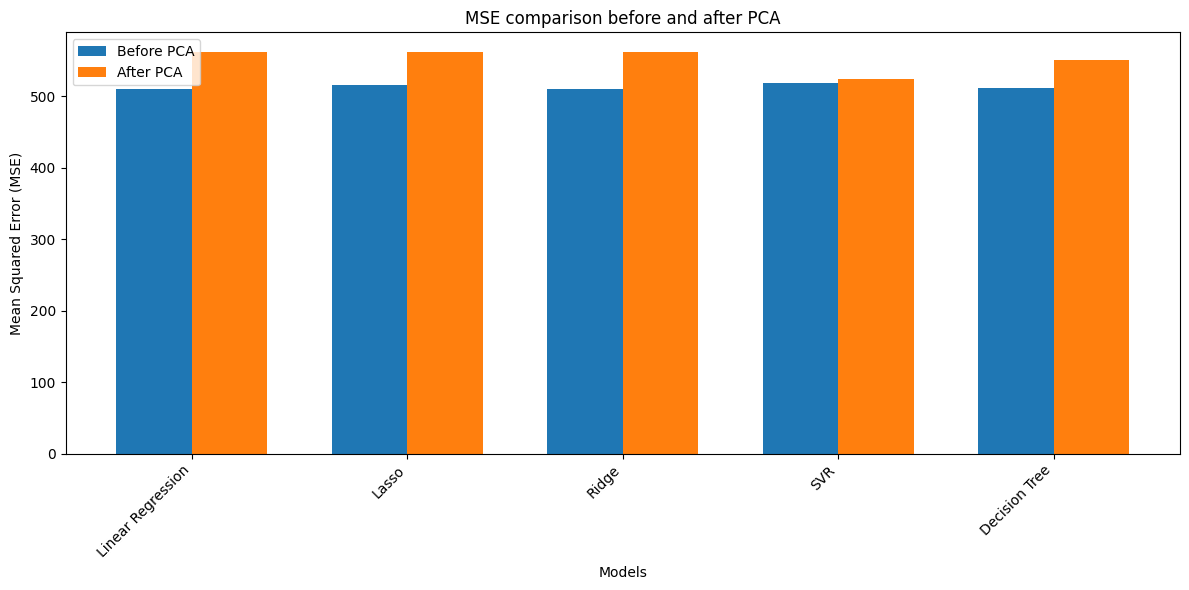

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Models before PCA
models_before_pca = {
    "Linear Regression": best_lr_b,
    "Lasso": best_lasso_b,
    "Ridge": best_ridge_b,
    "SVR": best_svr,
    "Decision Tree": best_dtr
}

mse_scores_before_pca = {}
for name, model in models_before_pca.items():
    mse_scores_before_pca[name] = evaluate_model(model, X_train_std, X_test_std, y_train, y_test)

# Models after PCA
models_after_pca = {
    "Linear Regression PCA": best_lr_pca,
    "Lasso PCA": best_lasso_pca,
    "Ridge PCA": best_ridge_pca,
    "SVR PCA": best_svr_pca,
    "Decision Tree PCA": best_dtr_pca
}

mse_scores_after_pca = {}
for name, model in models_after_pca.items():
    mse_scores_after_pca[name] = evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

models = list(models_before_pca.keys())
mse_before = list(mse_scores_before_pca.values())
mse_after = list(mse_scores_after_pca.values())

bar_width = 0.35
index = np.arange(len(models))

bar1 = ax.bar(index, mse_before, bar_width, label='Before PCA')
bar2 = ax.bar(index + bar_width, mse_after, bar_width, label='After PCA')

ax.set_xlabel('Models')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE comparison before and after PCA')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


## Final training and comparison

### Final training on the test subset

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate MSE and R2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, r2

# Models before PCA
models_before_pca = {
    "Linear Regression": best_lr_b,
    "Lasso": best_lasso_b,
    "Ridge": best_ridge_b,
    "SVR": best_svr,
    "Decision Tree": best_dtr
}

mse_scores_before_pca = {}
r2_scores_before_pca = {}
for name, model in models_before_pca.items():
    mse_scores_before_pca[name], r2_scores_before_pca[name] = evaluate_model(model, X_train_std, X_test_std, y_train, y_test)

# Models after PCA
models_after_pca = {
    "Linear Regression PCA": best_lr_pca,
    "Lasso PCA": best_lasso_pca,
    "Ridge PCA": best_ridge_pca,
    "SVR PCA": best_svr_pca,
    "Decision Tree PCA": best_dtr_pca
}

mse_scores_after_pca = {}
r2_scores_after_pca = {}
for name, model in models_after_pca.items():
    mse_scores_after_pca[name], r2_scores_after_pca[name] = evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test)


### MSE

MSE scores before PCA:
Linear Regression: 510.103
Lasso: 516.102
Ridge: 510.113
SVR: 518.556
Decision Tree: 510.808

MSE scores after PCA:
Linear Regression PCA: 561.289
Lasso PCA: 561.270
Ridge PCA: 561.289
SVR PCA: 523.417
Decision Tree PCA: 550.158


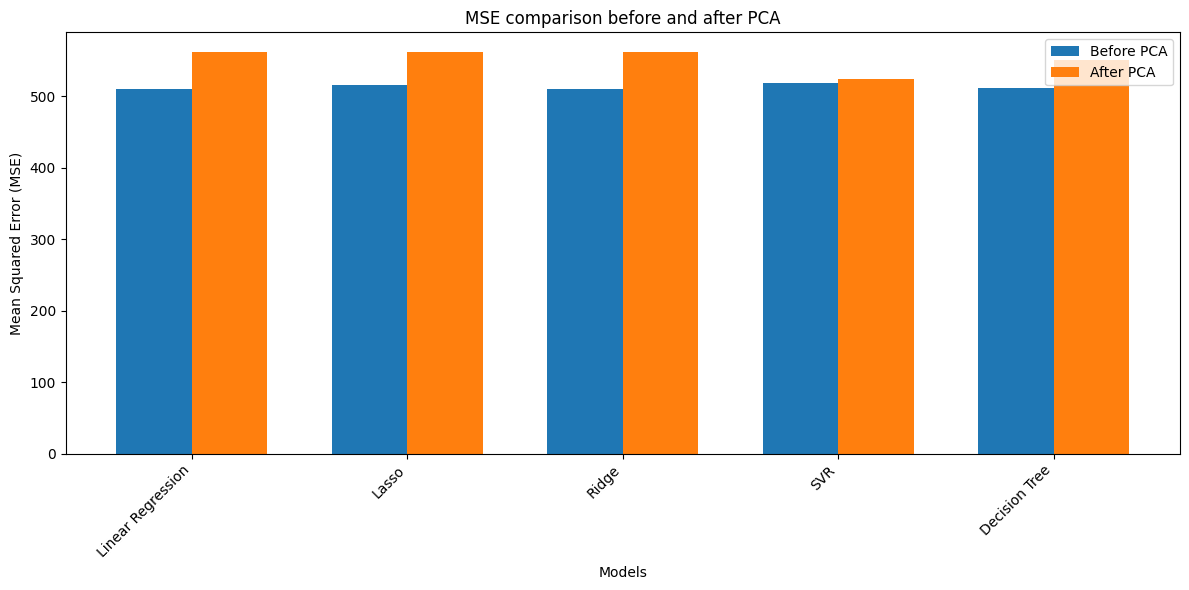

In [109]:
# Print MSE scores before and after PCA
print("MSE scores before PCA:")
for name, mse_score in mse_scores_before_pca.items():
    print(f"{name}: {mse_score:.3f}")

print("\nMSE scores after PCA:")
for name, mse_score in mse_scores_after_pca.items():
    print(f"{name}: {mse_score:.3f}")

# Plot MSE comparison before and after PCA
fig, ax = plt.subplots(figsize=(12, 6))

models = list(models_before_pca.keys())
mse_before = list(mse_scores_before_pca.values())
mse_after = list(mse_scores_after_pca.values())

bar_width = 0.35
index = np.arange(len(models))

bar1 = ax.bar(index, mse_before, bar_width, label='Before PCA')
bar2 = ax.bar(index + bar_width, mse_after, bar_width, label='After PCA')

ax.set_xlabel('Models')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE comparison before and after PCA')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


### R2

R2 scores before PCA:
Linear Regression: 0.161
Lasso: 0.151
Ridge: 0.160
SVR: 0.147
Decision Tree: 0.159

R2 scores after PCA:
Linear Regression PCA: 0.076
Lasso PCA: 0.076
Ridge PCA: 0.076
SVR PCA: 0.139
Decision Tree PCA: 0.095


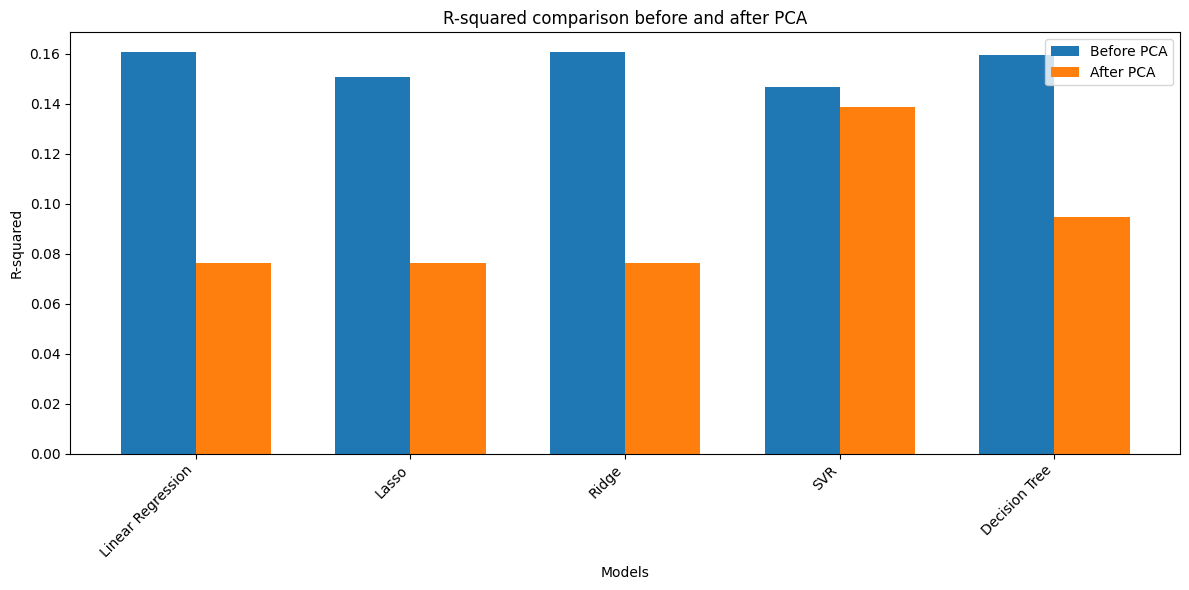

In [108]:
# Print R2 scores before and after PCA
print("R2 scores before PCA:")
for name, r2_score in r2_scores_before_pca.items():
    print(f"{name}: {r2_score:.3f}")

print("\nR2 scores after PCA:")
for name, r2_score in r2_scores_after_pca.items():
    print(f"{name}: {r2_score:.3f}")

# Plot R2 comparison before and after PCA
fig, ax = plt.subplots(figsize=(12, 6))

r2_before = list(r2_scores_before_pca.values())
r2_after = list(r2_scores_after_pca.values())

bar1 = ax.bar(index, r2_before, bar_width, label='Before PCA')
bar2 = ax.bar(index + bar_width, r2_after, bar_width, label='After PCA')

ax.set_xlabel('Models')
ax.set_ylabel('R-squared')
ax.set_title('R-squared comparison before and after PCA')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()
